# **1. sqlite**
SQLite는 서버가 필요 없는 가볍고(self-contained) 독립적인 관계형 데이터베이스 관리 시스템(RDBMS)으로, 애플리케이션 내부에 파일 형태로 데이터베이스를 저장해 별도의 설치나 설정 없이 쉽게 사용할 수 있다는 특징이 있습니다. ANSI-SQL 표준을 대부분 지원하며, 트랜잭션, 인덱스, 뷰, 트리거 같은 기능도 제공하지만 MySQL이나 PostgreSQL 같은 대형 서버형 DBMS에 비해 동시성 처리나 고성능 분산 처리에는 한계가 있습니다. 작은 규모의 웹·모바일 앱, 프로토타입 개발, 내장형 기기 등에 널리 활용되며, 파일 하나만 복사하면 전체 데이터베이스를 옮길 수 있을 만큼 간편성이 뛰어납니다.

In [1]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    with open("Chinook.db", "wb") as file:
        file.write(response.content)
    print("Chinook.db 다운로드")
else:
    print(f"다운로드 실패: {response.status_code}")

Chinook.db 다운로드


In [7]:
!pip install langchain_community

^C


In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}')

Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


In [3]:
from langchain_community.utilities import SQLDatabase
import os

db_path = "./Chinook.db"
print("경로 존재 여부:", os.path.exists(db_path))

db = SQLDatabase.from_uri(f"sqlite:///{db_path}")
print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}')

경로 존재 여부: True
Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


In [4]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [ ]:
!pip install langchain_openai

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0, max_retries=3)

**[SQLDatabaseToolkit](https://python.langchain.com/docs/integrations/tools/sql_database/)**

* sql_db_query: SQL 쿼리를 입력하면, 데이터베이스 조회 결과를 출력하는 도구로, 쿼리가 올바르지 않으면 오류 메시지가 반환됨.
* sql_db_schema: 테이블 목록을 입력하면 해당 테이블의 스키마와 샘플 행이 출력되는 도구.
* sql_db_list_tables: 데이터베이스 테이블 목록을 반환하는 도구.
* sql_db_query_checker: 쿼리가 올바른지 확인하는 도구.

In [6]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [7]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 14.2 MB/s eta 0:00:00


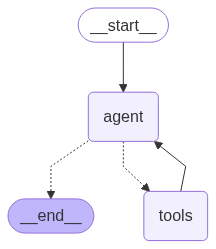

In [8]:
from langgraph.prebuilt import create_react_agent

system_prompt = f"""
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {db.dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most 5 results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
"""

agent = create_react_agent(
    llm,
    tools,
    prompt=system_prompt,
)

agent

In [9]:
question = "2009년에 가장 많은 매출을 올린 영업 사원은 누구인가요?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

2009년에 가장 많은 매출을 올린 영업 사원은 누구인가요?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_t8ZMKEm7tOtPt1Oe2wTXuDz4)
 Call ID: call_t8ZMKEm7tOtPt1Oe2wTXuDz4
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_pBHxTvVQzItV9GJeGyWYLlPJ)
 Call ID: call_pBHxTvVQzItV9GJeGyWYLlPJ
  Args:
    table_names: Employee, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Employee" (
	"EmployeeId" INTEGER NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"FirstName" NVARCHAR(20) NOT NULL, 
	"Title" NVARCHAR(

In [10]:
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c68681822a0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c68681822a0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c68681822a0>),
 QuerySQLCheckerTool(description='Use this tool to double check

# **2. Agent 구축**

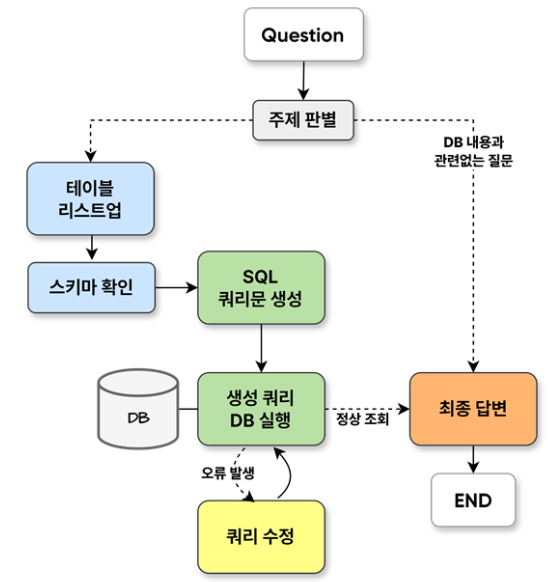

**2-1. ToolNode 생성하기**

In [11]:
from langgraph.prebuilt import ToolNode

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
list_tables_node = ToolNode([list_tables_tool], name="list_tables")

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")

**2-2. DB 조회 시작을 결정할 첫 노드 생성하기**

In [12]:
from langgraph.graph import END, START, MessagesState, StateGraph


def chatbot(state: MessagesState):
    llm_with_tools = llm.bind_tools([list_tables_tool])
    response = llm_with_tools.invoke(state["messages"]) # tool_calls : DB 조회가 필요 / AIMessage : DB 조회가 필요X
    return {"messages": [response]}

**2-3. 스키마 조회를 위한 도구 호출**

In [13]:
def call_get_schema(state: MessagesState):
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"]) # tool_calls : 필요한 테이블에 대한 스키마 요청

    return {"messages": [response]}

**2-4. 사용자 질문 기반 쿼리문 생성하기**

In [14]:
from langchain_core.prompts import ChatPromptTemplate

generate_query_system_prompt = f"""
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {db.dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most 5 results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
DO NOT wrap the response in any backticks or anything else(```). Respond with a SQL statement only!
"""

generate_query_user_prompt = """
User input: {question}
Schema: {schema}

If an error message is given, regenerate the query based on the error message.
History: {history}

SQL query:"""


def generate_query(state: MessagesState):
    print("##### GENERATE QUERY #####")
    print(state["messages"])
    history = ""
    for message in state["messages"][2:]:
        history += message.content + "\n"


    generate_query_msgs = [
        ("system", generate_query_system_prompt),
        ("user", generate_query_user_prompt),
    ]
    generate_propmt = ChatPromptTemplate.from_messages(generate_query_msgs)

    response = llm.invoke(generate_propmt.format_messages(
        question=state["messages"][0].content,
        schema=state["messages"][1].content,
        history=history
    ))
    print("generate_query", response)

    return {"messages": [response]}

**2-5. 생성한 쿼리문 실행하기**

In [15]:
from langchain_core.messages import AIMessage
import re  # 파일 상단 임포트

def _sanitize_sql(text: str) -> str:
    m = re.search(r"```(?:sql)?\s*(.*?)```", text, flags=re.DOTALL | re.IGNORECASE)
    return (m.group(1) if m else text).strip()

def check_query(state: MessagesState):
    print("##### CHECK QUERY #####")
    raw = state["messages"][-1].content
    query = _sanitize_sql(raw)                 # <-- 코드펜스 제거 포인트
    print("check_query", query)
    response = run_query_tool.invoke({"query": query})
    return {"messages": [AIMessage(content=str(response))]}

**2-6. 질문 + 쿼리 실행 결과 기반 답변 생성하기**

In [16]:
answer_system_prompt = """
You are a highly intelligent assistant trained to provide concise and accurate answers.
You will be given a context that has been retrieved from a database using a specific SQL query.
Your task is to analyze the context and answer the user’s question based on the information provided in the context.
ANSWER IN KOREAN.
"""

def answer(state: MessagesState):
    print("##### ANSWER #####")
    question = state["messages"][0].content
    context = state["messages"][-1].content
    generated_query = state["messages"][-2].content
    print("context", context)

    answer_msgs = [
        ("system", answer_system_prompt),
        ("user", "User Question: {question} SQL Query: {generated_query} Context: {context}"),
    ]
    answer_propmt = ChatPromptTemplate.from_messages(answer_msgs)

    response = llm.invoke(answer_propmt.format_messages(question=question, generated_query=generated_query, context=context))
    print("response", response)

    return {"messages": [response]}

**2-7. Graph Compile**

In [17]:
from langgraph.prebuilt import tools_condition

graph_builder = StateGraph(MessagesState)
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")

graph_builder.add_node("list_tables", list_tables_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "list_tables",
        END: END,
    },
)

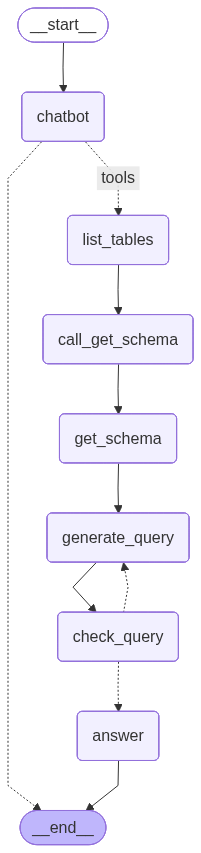

In [18]:
graph_builder.add_node("call_get_schema", call_get_schema)
graph_builder.add_node("get_schema", get_schema_node)
graph_builder.add_node("generate_query", generate_query)
graph_builder.add_node("check_query", check_query)
graph_builder.add_node("answer", answer)

graph_builder.add_edge("list_tables", "call_get_schema")
graph_builder.add_edge("call_get_schema", "get_schema")
graph_builder.add_edge("get_schema", "generate_query")
graph_builder.add_edge("generate_query", "check_query")


def should_correct(state):
    print(state["messages"][-1].content)
    txt = state["messages"][-1].content
    if "Error:" in txt or "error" in txt.lower(): # DB 조회 결과가 [-1] 에 저장
        return "generate_query"
    else:
        return "answer"

graph_builder.add_conditional_edges(
    "check_query",
    should_correct,
    {
        "generate_query": "generate_query",
        "answer": "answer",
    },
)


graph_builder.add_edge("answer", END)

graph = graph_builder.compile()
graph

In [19]:
question = "2009년에 가장 많은 매출을 올린 영업 사원은 누구인가요?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

2009년에 가장 많은 매출을 올린 영업 사원은 누구인가요?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_MeKjOHfgcjyBicbLYVNR1hWQ)
 Call ID: call_MeKjOHfgcjyBicbLYVNR1hWQ
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_ZpknEiy355RP4rcjnSjSCEeP)
 Call ID: call_ZpknEiy355RP4rcjnSjSCEeP
  Args:
    table_names: Employee
  sql_db_schema (call_LKYbNQYf1iQbYxpiYKYCZ0fj)
 Call ID: call_LKYbNQYf1iQbYxpiYKYCZ0fj
  Args:
    table_names: Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Invoice"

In [20]:
question = "DB 조회를 기반으로 2009년 가장 많은 양의 음반을 판매한 아티스트의 해당 앨범 판매 기간을 알려주세요. "

for step in graph.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

DB 조회를 기반으로 2009년 가장 많은 양의 음반을 판매한 아티스트의 해당 앨범 판매 기간을 알려주세요. 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_TjvJBZoNQXweYD85MUa0zk00)
 Call ID: call_TjvJBZoNQXweYD85MUa0zk00
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_1j3lGqdxpwIkRTM7yjhUyQhG)
 Call ID: call_1j3lGqdxpwIkRTM7yjhUyQhG
  Args:
    table_names: Album, Artist, Invoice, InvoiceLine
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	